In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/ParkDatasets/ParkDatasetAug'
class_names = ['Aedes albopictus', 'Aedes vexans', 'Anopheles sinensis', 'Culex pipiens', 'Culex tritaeniorhynchus', 'Non vectors']

SDO = 0.6

NUM_EPOCH_PER_TRAIN = 40

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 10

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.80, 0.2, 0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=15, restore_best_weights = True)


2022-09-30 08:28:05.414629: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add


In [3]:
def buildSDModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(SDO)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(SDO)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(SDO)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(SDO)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(SDO)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(6, activation='softmax')(drop_2)
    model = Model(inputs=input0, outputs=output)
    return model

In [4]:
def loadVGG16ImageNetWeightsSD(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[1].set_weights(layer.get_weights()),
        elif layer.name == 'block1_conv2': 
            model.layers[2].set_weights(layer.get_weights()),
        elif layer.name == 'block2_conv1': 
            model.layers[5].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[6].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[9].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[16].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[27].set_weights(layer.get_weights())
    return model


In [5]:
def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

In [6]:
def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            SelectedFiles = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )

In [7]:
def read_ds(src_dir):
    
    train_dir = src_dir  + '/train'
    val_dir = src_dir    + '/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    return (train_ds, val_ds)



In [8]:
def preprocessDS(train_ds, val_ds):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))




    # Load the dataset onto GPU RAM for superspeed
    train_ds = train_ds.cache()
    val_ds = val_ds.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds = train_ds.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds   = val_ds.shuffle(val_num_batch, reshuffle_each_iteration=False)


    # prefetch the datasets for lower latency
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    return (train_ds, val_ds)
    #...

In [9]:
def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model


In [10]:
def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    history = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    return history

In [11]:
def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [12]:
def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


In [13]:
def saveSDOModel(model):
    path = './models/Model_SDO_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

In [14]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpii2chbf_/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpii2chbf_/train/Aedes vexans/ = 4738.
No. of files in "/tmp/tmpii2chbf_/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpii2chbf_/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpii2chbf_/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpii2chbf_/val/Aedes vexans/ = 1163.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpii2chbf_/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpii2chbf_/train/Anopheles sinensis/ = 4745.
No. of files in "/tmp/tmpii2chbf_/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpii2chbf_/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpii2chbf_/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpii2chbf_/val/Anopheles sinensis/ = 1178.
Foun

In [15]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)

Found 28651 files belonging to 6 classes.


2022-09-25 09:19:18.091977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 09:19:18.846268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22211 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 7089 files belonging to 6 classes.


In [16]:
model = buildSDModel()
model.summary()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img0 (InputLayer)           [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 112, 112, 64)     0         
 ropout2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856 

In [17]:
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
maxAcc = np.max(fitHistory.history['val_accuracy'])

Start fitting from 2022/09/25-09:19:26

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-25 09:19:33.195023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-25 09:19:35.421981: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3582/3582 [==============================] - 244s 65ms/step - loss: 1.8332 - accuracy: 0.1665 - val_loss: 1.7471 - val_accuracy: 0.2563 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3582/3582 [==============================] - 220s 61ms/step - loss: 1.6737 - accuracy: 0.2649 - val_loss: 1.4515 - val_accuracy: 0.3572 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3582/3582 [==============================] - 220s 61ms/step - loss: 1.4127 - accuracy: 0.4023 - val_loss: 1.2396 - val_accuracy: 0.5026 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3582/3582 [==============================] - 220s 61ms/step - loss: 1.2134 - accuracy: 0.5157 - val_loss: 1.0142 - val_accuracy: 0.6012 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
3582/3582 [=========

Maximum test accuracy is at 92.21 %.


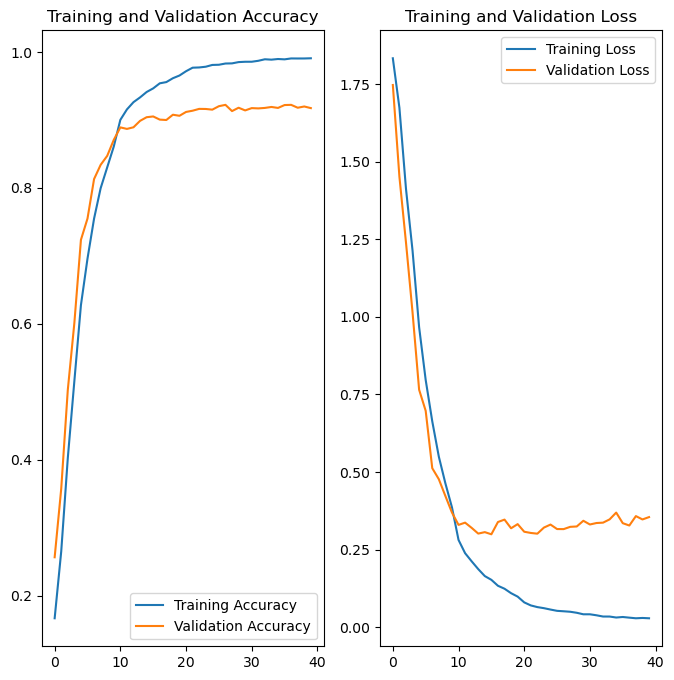

In [18]:
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [19]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

887/887 [==============================] - 14s 15ms/step
Confusion Matrix
[[1141   23    5    2   19    7]
 [   7 1065   18    1   41   31]
 [   9   67 1047   10   15   30]
 [   0   12    3 1159    0   13]
 [   1   56    1    2 1107    2]
 [   6   81   35   82    7  984]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.98      0.95      0.97      1197
           Aedes vexans       0.82      0.92      0.86      1163
     Anopheles sinensis       0.94      0.89      0.92      1178
          Culex pipiens       0.92      0.98      0.95      1187
Culex tritaeniorhynchus       0.93      0.95      0.94      1169
            Non vectors       0.92      0.82      0.87      1195

               accuracy                           0.92      7089
              macro avg       0.92      0.92      0.92      7089
           weighted avg       0.92      0.92      0.92      7089

Model is saved in ./models/Model_SDO_Park_2022-09-

In [20]:
#-----Run 2

In [21]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpwq97m4n5/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpwq97m4n5/train/Aedes vexans/ = 4723.
No. of files in "/tmp/tmpwq97m4n5/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpwq97m4n5/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpwq97m4n5/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpwq97m4n5/val/Aedes vexans/ = 1178.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpwq97m4n5/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpwq97m4n5/train/Anopheles sinensis/ = 4740.
No. of files in "/tmp/tmpwq97m4n5/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpwq97m4n5/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpwq97m4n5/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpwq97m4n5/val/Anopheles sinensis/ = 1183.
Foun

In [22]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28642 files belonging to 6 classes.
Found 7098 files belonging to 6 classes.


In [23]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/25-11:43:41

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3581/3581 [==============================] - 222s 60ms/step - loss: 1.8346 - accuracy: 0.1718 - val_loss: 1.7670 - val_accuracy: 0.1734 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3581/3581 [==============================] - 223s 62ms/step - loss: 1.6557 - accuracy: 0.2745 - val_loss: 1.4084 - val_accuracy: 0.4038 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3581/3581 [==============================] - 216s 60ms/step - loss: 1.4098 - accuracy: 0.3993 - val_loss: 1.2730 - val_accuracy: 0.4718 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3581/3581 [==============================] - 214s 60ms/step - loss: 1.2369 - accuracy: 0.5036 - val_loss: 1.0452 - val_accuracy: 0.597

Epoch 34/40
3581/3581 [==============================] - 213s 59ms/step - loss: 0.0314 - accuracy: 0.9901 - val_loss: 0.3718 - val_accuracy: 0.9138 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3581/3581 [==============================] - 214s 60ms/step - loss: 0.0317 - accuracy: 0.9895 - val_loss: 0.3869 - val_accuracy: 0.9118 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3581/3581 [==============================] - 213s 60ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.3908 - val_accuracy: 0.9084 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3581/3581 [==============================] - 212s 59ms/step - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.3872 - val_accuracy: 0.9101 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3581

Maximum test accuracy is at 91.62 %.


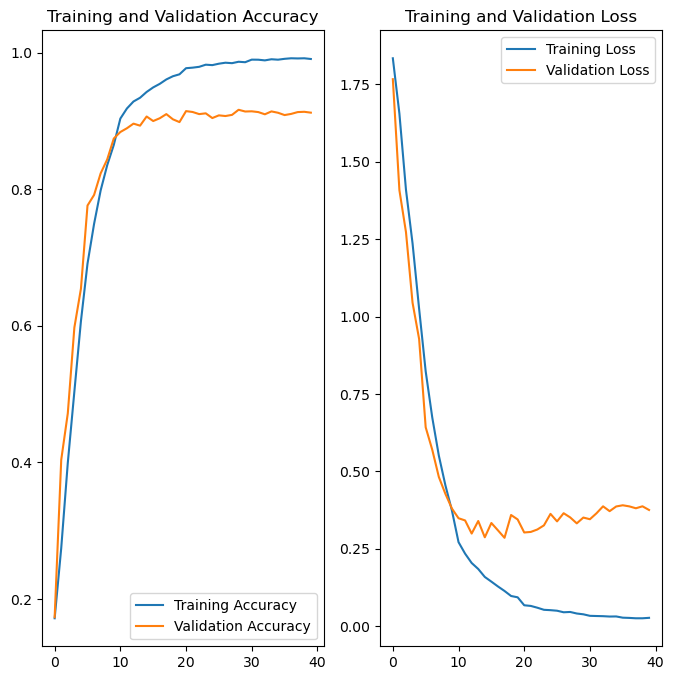

In [24]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [25]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

888/888 [==============================] - 14s 15ms/step
Confusion Matrix
[[1122   38   13   10   11    4]
 [   0 1072   31   12   42   21]
 [   0   64 1069    9   10   31]
 [   2    5   16 1142    0   21]
 [   4   67    1    0 1077   12]
 [   3   72   52   69    5  991]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.94      0.96      1198
           Aedes vexans       0.81      0.91      0.86      1178
     Anopheles sinensis       0.90      0.90      0.90      1183
          Culex pipiens       0.92      0.96      0.94      1186
Culex tritaeniorhynchus       0.94      0.93      0.93      1161
            Non vectors       0.92      0.83      0.87      1192

               accuracy                           0.91      7098
              macro avg       0.91      0.91      0.91      7098
           weighted avg       0.91      0.91      0.91      7098

Model is saved in ./models/Model_SDO_Park_2022-09-

In [26]:
#-----Run 3

In [27]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp9li23cdb/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp9li23cdb/train/Aedes vexans/ = 4722.
No. of files in "/tmp/tmp9li23cdb/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp9li23cdb/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp9li23cdb/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp9li23cdb/val/Aedes vexans/ = 1179.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp9li23cdb/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp9li23cdb/train/Anopheles sinensis/ = 4745.
No. of files in "/tmp/tmp9li23cdb/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp9li23cdb/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp9li23cdb/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp9li23cdb/val/Anopheles sinensis/ = 1178.
Foun

In [28]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28668 files belonging to 6 classes.
Found 7072 files belonging to 6 classes.


In [29]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/25-14:07:25

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3584/3584 [==============================] - 224s 61ms/step - loss: 1.8364 - accuracy: 0.1680 - val_loss: 1.7736 - val_accuracy: 0.1937 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3584/3584 [==============================] - 213s 60ms/step - loss: 1.7418 - accuracy: 0.2205 - val_loss: 1.4855 - val_accuracy: 0.3708 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3584/3584 [==============================] - 213s 59ms/step - loss: 1.4600 - accuracy: 0.3797 - val_loss: 1.3391 - val_accuracy: 0.4443 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3584/3584 [==============================] - 212s 59ms/step - loss: 1.2912 - accuracy: 0.4683 - val_loss: 1.3800 - val_accuracy: 0.431

Epoch 34/40
3584/3584 [==============================] - 211s 59ms/step - loss: 0.0339 - accuracy: 0.9888 - val_loss: 0.4522 - val_accuracy: 0.9067 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3584/3584 [==============================] - 212s 59ms/step - loss: 0.0327 - accuracy: 0.9890 - val_loss: 0.4426 - val_accuracy: 0.9065 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3584/3584 [==============================] - 213s 59ms/step - loss: 0.0301 - accuracy: 0.9903 - val_loss: 0.4750 - val_accuracy: 0.9041 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3584/3584 [==============================] - 212s 59ms/step - loss: 0.0299 - accuracy: 0.9907 - val_loss: 0.4767 - val_accuracy: 0.9026 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3584

Maximum test accuracy is at 91.02 %.


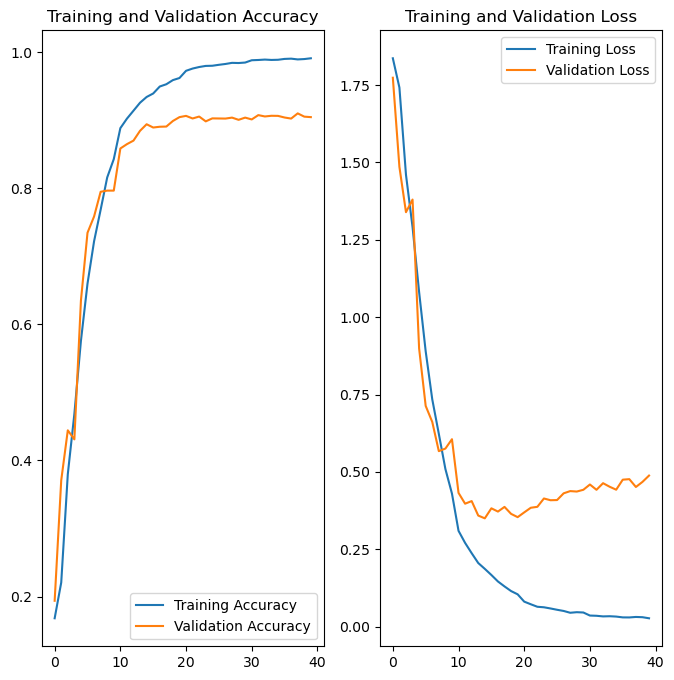

In [30]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [31]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

884/884 [==============================] - 14s 15ms/step
Confusion Matrix
[[1129   13   15   10   15    3]
 [   6 1010   10   23  118   12]
 [   0   33 1092   10   14   29]
 [   3    1   12 1136    0   12]
 [   0   57    5    0 1094    9]
 [   2   91   68   88   15  937]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.95      0.97      1185
           Aedes vexans       0.84      0.86      0.85      1179
     Anopheles sinensis       0.91      0.93      0.92      1178
          Culex pipiens       0.90      0.98      0.93      1164
Culex tritaeniorhynchus       0.87      0.94      0.90      1165
            Non vectors       0.94      0.78      0.85      1201

               accuracy                           0.90      7072
              macro avg       0.91      0.91      0.90      7072
           weighted avg       0.91      0.90      0.90      7072

Model is saved in ./models/Model_SDO_Park_2022-09-

In [32]:
#-----Run 4

In [33]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmphpfa1twg/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmphpfa1twg/train/Aedes vexans/ = 4732.
No. of files in "/tmp/tmphpfa1twg/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmphpfa1twg/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmphpfa1twg/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmphpfa1twg/val/Aedes vexans/ = 1169.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmphpfa1twg/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmphpfa1twg/train/Anopheles sinensis/ = 4744.
No. of files in "/tmp/tmphpfa1twg/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmphpfa1twg/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmphpfa1twg/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmphpfa1twg/val/Anopheles sinensis/ = 1179.
Foun

In [34]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28649 files belonging to 6 classes.
Found 7091 files belonging to 6 classes.


In [35]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/25-16:29:52

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3582/3582 [==============================] - 217s 59ms/step - loss: 1.8333 - accuracy: 0.1762 - val_loss: 1.7931 - val_accuracy: 0.1663 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3582/3582 [==============================] - 209s 58ms/step - loss: 1.6937 - accuracy: 0.2518 - val_loss: 1.4465 - val_accuracy: 0.3854 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3582/3582 [==============================] - 213s 60ms/step - loss: 1.4199 - accuracy: 0.3958 - val_loss: 1.2606 - val_accuracy: 0.4829 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3582/3582 [==============================] - 213s 59ms/step - loss: 1.2349 - accuracy: 0.5021 - val_loss: 1.0125 - val_accuracy: 0.580

Epoch 34/40
3582/3582 [==============================] - 212s 59ms/step - loss: 0.0242 - accuracy: 0.9921 - val_loss: 0.4679 - val_accuracy: 0.9003 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3582/3582 [==============================] - 214s 60ms/step - loss: 0.0235 - accuracy: 0.9921 - val_loss: 0.4696 - val_accuracy: 0.9031 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3582/3582 [==============================] - 213s 60ms/step - loss: 0.0229 - accuracy: 0.9923 - val_loss: 0.4722 - val_accuracy: 0.9014 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3582/3582 [==============================] - 212s 59ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 0.4381 - val_accuracy: 0.9044 - lr: 2.5000e-06
End fitting at 2022/09/25-18:41:18


Maximum test accuracy is at 90.89 %.


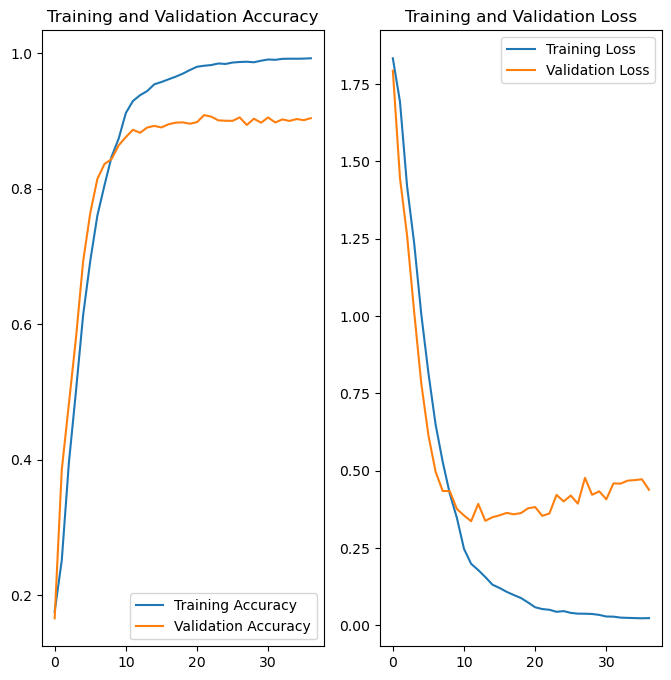

In [36]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [37]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

887/887 [==============================] - 13s 15ms/step
Confusion Matrix
[[1141   21   12    7    8   10]
 [   5 1015   32   33   45   39]
 [  10   38 1075   18   11   27]
 [   2    1   25 1140    0   10]
 [   4   72    3    0 1086    7]
 [   0   40   51  102   13  988]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.98      0.95      0.97      1199
           Aedes vexans       0.86      0.87      0.86      1169
     Anopheles sinensis       0.90      0.91      0.90      1179
          Culex pipiens       0.88      0.97      0.92      1178
Culex tritaeniorhynchus       0.93      0.93      0.93      1172
            Non vectors       0.91      0.83      0.87      1194

               accuracy                           0.91      7091
              macro avg       0.91      0.91      0.91      7091
           weighted avg       0.91      0.91      0.91      7091

Model is saved in ./models/Model_SDO_Park_2022-09-

In [38]:
#-----Run 5

In [39]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpacex9xvf/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpacex9xvf/train/Aedes vexans/ = 4723.
No. of files in "/tmp/tmpacex9xvf/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpacex9xvf/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpacex9xvf/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpacex9xvf/val/Aedes vexans/ = 1178.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpacex9xvf/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpacex9xvf/train/Anopheles sinensis/ = 4759.
No. of files in "/tmp/tmpacex9xvf/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpacex9xvf/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpacex9xvf/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpacex9xvf/val/Anopheles sinensis/ = 1164.
Foun

In [40]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28672 files belonging to 6 classes.
Found 7068 files belonging to 6 classes.


In [41]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/25-18:41:53

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3584/3584 [==============================] - 221s 60ms/step - loss: 1.8370 - accuracy: 0.1621 - val_loss: 1.7886 - val_accuracy: 0.1713 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3584/3584 [==============================] - 213s 59ms/step - loss: 1.7506 - accuracy: 0.2149 - val_loss: 1.5110 - val_accuracy: 0.3217 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3584/3584 [==============================] - 215s 60ms/step - loss: 1.4642 - accuracy: 0.3791 - val_loss: 1.3025 - val_accuracy: 0.4686 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3584/3584 [==============================] - 213s 60ms/step - loss: 1.2663 - accuracy: 0.4902 - val_loss: 1.0007 - val_accuracy: 0.607

Epoch 34/40
3584/3584 [==============================] - 223s 62ms/step - loss: 0.0317 - accuracy: 0.9890 - val_loss: 0.4057 - val_accuracy: 0.9131 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3584/3584 [==============================] - 221s 62ms/step - loss: 0.0309 - accuracy: 0.9899 - val_loss: 0.3962 - val_accuracy: 0.9143 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3584/3584 [==============================] - 222s 62ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.4015 - val_accuracy: 0.9131 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3584/3584 [==============================] - 211s 59ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.4144 - val_accuracy: 0.9128 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3584

Maximum test accuracy is at 91.67 %.


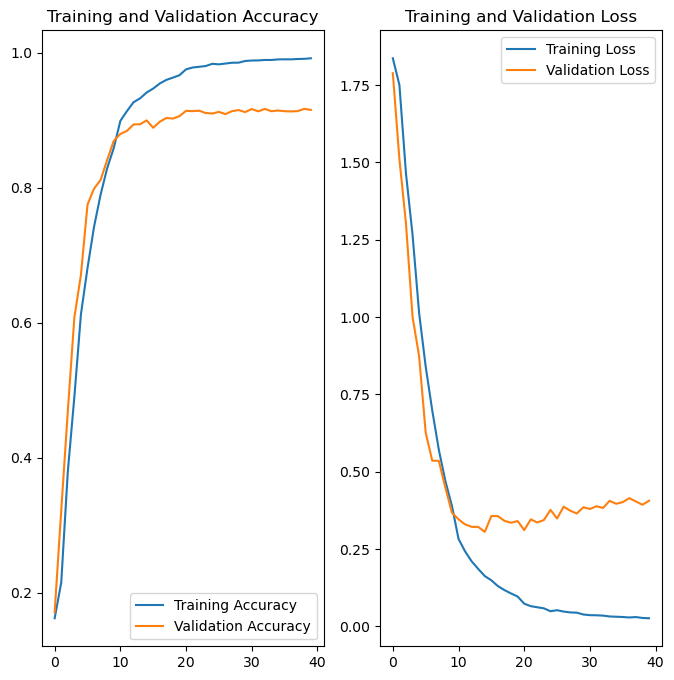

In [42]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [43]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

884/884 [==============================] - 15s 17ms/step
Confusion Matrix
[[1139   34   12    1    6    7]
 [   4 1085    9   12   43   25]
 [   7   46 1034   19    6   52]
 [   1    5   16 1153    0   15]
 [   2   80    1    0 1100    4]
 [  12   74   45   57    5  957]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.98      0.95      0.96      1199
           Aedes vexans       0.82      0.92      0.87      1178
     Anopheles sinensis       0.93      0.89      0.91      1164
          Culex pipiens       0.93      0.97      0.95      1190
Culex tritaeniorhynchus       0.95      0.93      0.94      1187
            Non vectors       0.90      0.83      0.87      1150

               accuracy                           0.92      7068
              macro avg       0.92      0.91      0.91      7068
           weighted avg       0.92      0.92      0.92      7068

Model is saved in ./models/Model_SDO_Park_2022-09-

In [44]:
#-----Run 6

In [45]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp_ah0dktm/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp_ah0dktm/train/Aedes vexans/ = 4725.
No. of files in "/tmp/tmp_ah0dktm/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp_ah0dktm/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp_ah0dktm/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp_ah0dktm/val/Aedes vexans/ = 1176.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp_ah0dktm/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp_ah0dktm/train/Anopheles sinensis/ = 4739.
No. of files in "/tmp/tmp_ah0dktm/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp_ah0dktm/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp_ah0dktm/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp_ah0dktm/val/Anopheles sinensis/ = 1184.
Foun

In [46]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28682 files belonging to 6 classes.
Found 7058 files belonging to 6 classes.


In [47]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/25-21:05:25

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3586/3586 [==============================] - 222s 60ms/step - loss: 1.8346 - accuracy: 0.1638 - val_loss: 1.7850 - val_accuracy: 0.1666 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3586/3586 [==============================] - 216s 60ms/step - loss: 1.7759 - accuracy: 0.1977 - val_loss: 1.5615 - val_accuracy: 0.3447 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3586/3586 [==============================] - 215s 60ms/step - loss: 1.4962 - accuracy: 0.3634 - val_loss: 1.2870 - val_accuracy: 0.4073 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3586/3586 [==============================] - 211s 59ms/step - loss: 1.2636 - accuracy: 0.4929 - val_loss: 1.0389 - val_accuracy: 0.608

Epoch 34/40
3586/3586 [==============================] - 211s 59ms/step - loss: 0.0329 - accuracy: 0.9897 - val_loss: 0.2808 - val_accuracy: 0.9328 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3586/3586 [==============================] - 211s 59ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.2819 - val_accuracy: 0.9345 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3586/3586 [==============================] - 210s 59ms/step - loss: 0.0289 - accuracy: 0.9903 - val_loss: 0.2869 - val_accuracy: 0.9340 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3586/3586 [==============================] - 211s 59ms/step - loss: 0.0313 - accuracy: 0.9898 - val_loss: 0.2922 - val_accuracy: 0.9316 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3586

Maximum test accuracy is at 93.58 %.


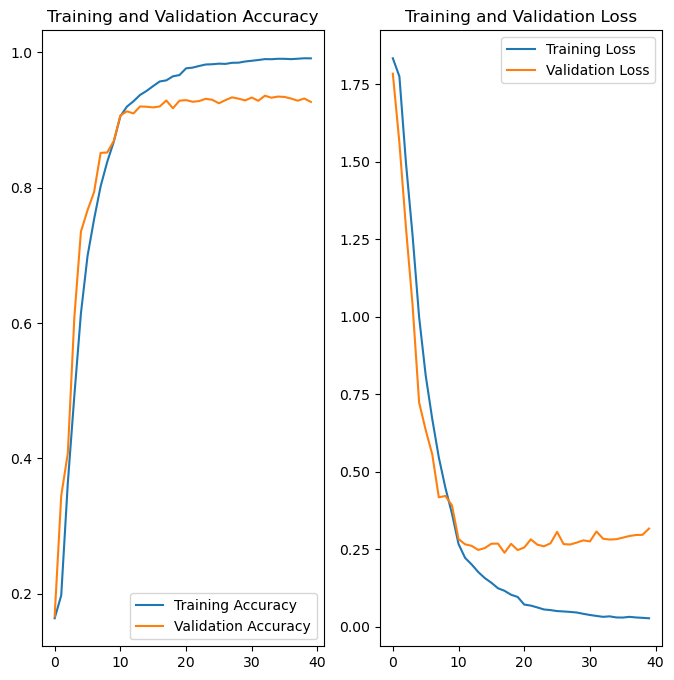

In [48]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [49]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

883/883 [==============================] - 14s 15ms/step
Confusion Matrix
[[1125   21   32    5    3    8]
 [   0 1100   13   12   33   18]
 [  12   36 1082   17   18   19]
 [   2    5   14 1153    0   10]
 [   4   68    6    1 1090    9]
 [   0   47   28   72    5  990]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.98      0.94      0.96      1194
           Aedes vexans       0.86      0.94      0.90      1176
     Anopheles sinensis       0.92      0.91      0.92      1184
          Culex pipiens       0.92      0.97      0.94      1184
Culex tritaeniorhynchus       0.95      0.93      0.94      1178
            Non vectors       0.94      0.87      0.90      1142

               accuracy                           0.93      7058
              macro avg       0.93      0.93      0.93      7058
           weighted avg       0.93      0.93      0.93      7058

Model is saved in ./models/Model_SDO_Park_2022-09-

In [14]:
#-----Run 7

In [15]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp8an0j9vj/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp8an0j9vj/train/Aedes vexans/ = 4738.
No. of files in "/tmp/tmp8an0j9vj/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp8an0j9vj/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp8an0j9vj/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp8an0j9vj/val/Aedes vexans/ = 1163.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp8an0j9vj/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp8an0j9vj/train/Anopheles sinensis/ = 4746.
No. of files in "/tmp/tmp8an0j9vj/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp8an0j9vj/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp8an0j9vj/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp8an0j9vj/val/Anopheles sinensis/ = 1177.
Foun

In [16]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28704 files belonging to 6 classes.


2022-09-30 08:29:28.545107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 08:29:29.334014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22218 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 7036 files belonging to 6 classes.


In [17]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/30-08:29:36

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-30 08:29:42.855105: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-30 08:29:45.138085: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3588/3588 [==============================] - 243s 65ms/step - loss: 1.8358 - accuracy: 0.1649 - val_loss: 1.7788 - val_accuracy: 0.2389 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3588/3588 [==============================] - 225s 63ms/step - loss: 1.7712 - accuracy: 0.2095 - val_loss: 1.6126 - val_accuracy: 0.2878 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3588/3588 [==============================] - 216s 60ms/step - loss: 1.5095 - accuracy: 0.3515 - val_loss: 1.3525 - val_accuracy: 0.3887 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3588/3588 [==============================] - 215s 60ms/step - loss: 1.3426 - accuracy: 0.4413 - val_loss: 1.2323 - val_accuracy: 0.5055 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
3588/3588 [=========

3588/3588 [==============================] - 206s 57ms/step - loss: 0.0392 - accuracy: 0.9868 - val_loss: 0.4565 - val_accuracy: 0.8911 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3588/3588 [==============================] - 208s 58ms/step - loss: 0.0342 - accuracy: 0.9887 - val_loss: 0.4585 - val_accuracy: 0.8930 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3588/3588 [==============================] - 204s 57ms/step - loss: 0.0369 - accuracy: 0.9879 - val_loss: 0.4651 - val_accuracy: 0.8903 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3588/3588 [==============================] - 210s 59ms/step - loss: 0.0351 - accuracy: 0.9883 - val_loss: 0.4695 - val_accuracy: 0.8937 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3588/3588 [=====

Maximum test accuracy is at 89.37 %.


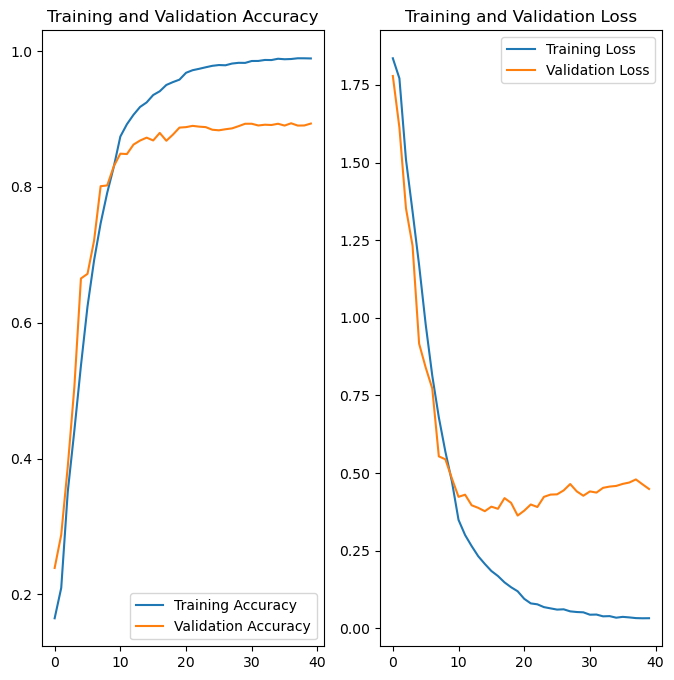

In [18]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [19]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

880/880 [==============================] - 14s 15ms/step
Confusion Matrix
[[1128    9    2   11   11   10]
 [   6  981   35   22   86   33]
 [  11   63 1026   19    0   58]
 [   0    2   20 1117    0   29]
 [  10  107    4    1 1032   16]
 [   9   65   17   80   15 1001]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.97      0.96      0.97      1171
           Aedes vexans       0.80      0.84      0.82      1163
     Anopheles sinensis       0.93      0.87      0.90      1177
          Culex pipiens       0.89      0.96      0.92      1168
Culex tritaeniorhynchus       0.90      0.88      0.89      1170
            Non vectors       0.87      0.84      0.86      1187

               accuracy                           0.89      7036
              macro avg       0.89      0.89      0.89      7036
           weighted avg       0.89      0.89      0.89      7036

Model is saved in ./models/Model_SDO_Park_2022-09-

In [20]:
#-----Run 8

In [21]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpecbm3_2f/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpecbm3_2f/train/Aedes vexans/ = 4725.
No. of files in "/tmp/tmpecbm3_2f/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpecbm3_2f/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpecbm3_2f/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpecbm3_2f/val/Aedes vexans/ = 1176.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpecbm3_2f/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpecbm3_2f/train/Anopheles sinensis/ = 4746.
No. of files in "/tmp/tmpecbm3_2f/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpecbm3_2f/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpecbm3_2f/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpecbm3_2f/val/Anopheles sinensis/ = 1177.
Foun

In [22]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28681 files belonging to 6 classes.
Found 7059 files belonging to 6 classes.


In [23]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/30-10:49:23

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3586/3586 [==============================] - 214s 58ms/step - loss: 1.8292 - accuracy: 0.1722 - val_loss: 1.7394 - val_accuracy: 0.2318 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3586/3586 [==============================] - 211s 59ms/step - loss: 1.6166 - accuracy: 0.2983 - val_loss: 1.3869 - val_accuracy: 0.3798 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3586/3586 [==============================] - 212s 59ms/step - loss: 1.3764 - accuracy: 0.4226 - val_loss: 1.2043 - val_accuracy: 0.5117 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3586/3586 [==============================] - 211s 59ms/step - loss: 1.1956 - accuracy: 0.5222 - val_loss: 1.0047 - val_accuracy: 0.619

Epoch 34/40
3586/3586 [==============================] - 202s 56ms/step - loss: 0.0269 - accuracy: 0.9909 - val_loss: 0.5852 - val_accuracy: 0.8848 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3586/3586 [==============================] - 204s 57ms/step - loss: 0.0288 - accuracy: 0.9907 - val_loss: 0.5413 - val_accuracy: 0.8867 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3586/3586 [==============================] - 203s 57ms/step - loss: 0.0274 - accuracy: 0.9910 - val_loss: 0.5516 - val_accuracy: 0.8858 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3586/3586 [==============================] - 202s 56ms/step - loss: 0.0256 - accuracy: 0.9916 - val_loss: 0.6246 - val_accuracy: 0.8816 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3586

Maximum test accuracy is at 88.67 %.


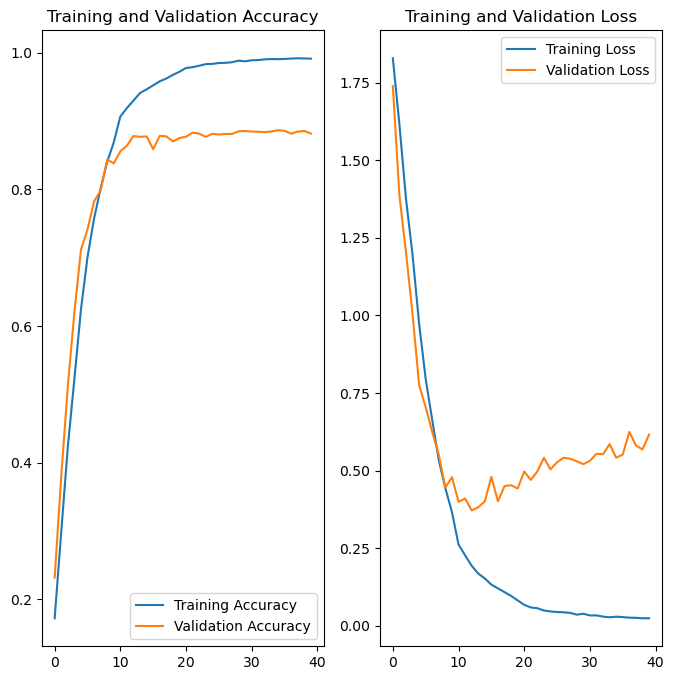

In [24]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [25]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

883/883 [==============================] - 14s 16ms/step
Confusion Matrix
[[1130   29    4    2   23    9]
 [   1 1069   18    3   57   28]
 [   9   91  979   21   19   58]
 [   3    1   10 1159    0   16]
 [   8   88    3    0 1057   16]
 [   3  100   49  160    5  831]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.98      0.94      0.96      1197
           Aedes vexans       0.78      0.91      0.84      1176
     Anopheles sinensis       0.92      0.83      0.87      1177
          Culex pipiens       0.86      0.97      0.91      1189
Culex tritaeniorhynchus       0.91      0.90      0.91      1172
            Non vectors       0.87      0.72      0.79      1148

               accuracy                           0.88      7059
              macro avg       0.89      0.88      0.88      7059
           weighted avg       0.89      0.88      0.88      7059

Model is saved in ./models/Model_SDO_Park_2022-09-

In [26]:
#-----Run 9

In [27]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpzb1aljsf/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpzb1aljsf/train/Aedes vexans/ = 4724.
No. of files in "/tmp/tmpzb1aljsf/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpzb1aljsf/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpzb1aljsf/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpzb1aljsf/val/Aedes vexans/ = 1177.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpzb1aljsf/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpzb1aljsf/train/Anopheles sinensis/ = 4739.
No. of files in "/tmp/tmpzb1aljsf/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpzb1aljsf/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpzb1aljsf/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpzb1aljsf/val/Anopheles sinensis/ = 1184.
Foun

In [28]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28712 files belonging to 6 classes.
Found 7028 files belonging to 6 classes.


In [29]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/30-13:07:35

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3589/3589 [==============================] - 213s 58ms/step - loss: 1.8345 - accuracy: 0.1645 - val_loss: 1.7721 - val_accuracy: 0.1895 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3589/3589 [==============================] - 209s 58ms/step - loss: 1.7539 - accuracy: 0.2206 - val_loss: 1.4987 - val_accuracy: 0.3379 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3589/3589 [==============================] - 206s 57ms/step - loss: 1.4618 - accuracy: 0.3796 - val_loss: 1.3241 - val_accuracy: 0.4942 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3589/3589 [==============================] - 206s 57ms/step - loss: 1.2573 - accuracy: 0.4907 - val_loss: 0.9549 - val_accuracy: 0.633

Epoch 34/40
3589/3589 [==============================] - 202s 56ms/step - loss: 0.0323 - accuracy: 0.9895 - val_loss: 0.3630 - val_accuracy: 0.9182 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3589/3589 [==============================] - 203s 56ms/step - loss: 0.0342 - accuracy: 0.9889 - val_loss: 0.3643 - val_accuracy: 0.9141 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3589/3589 [==============================] - 202s 56ms/step - loss: 0.0314 - accuracy: 0.9894 - val_loss: 0.3610 - val_accuracy: 0.9145 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3589/3589 [==============================] - 202s 56ms/step - loss: 0.0323 - accuracy: 0.9896 - val_loss: 0.3599 - val_accuracy: 0.9169 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3589

Maximum test accuracy is at 91.86 %.


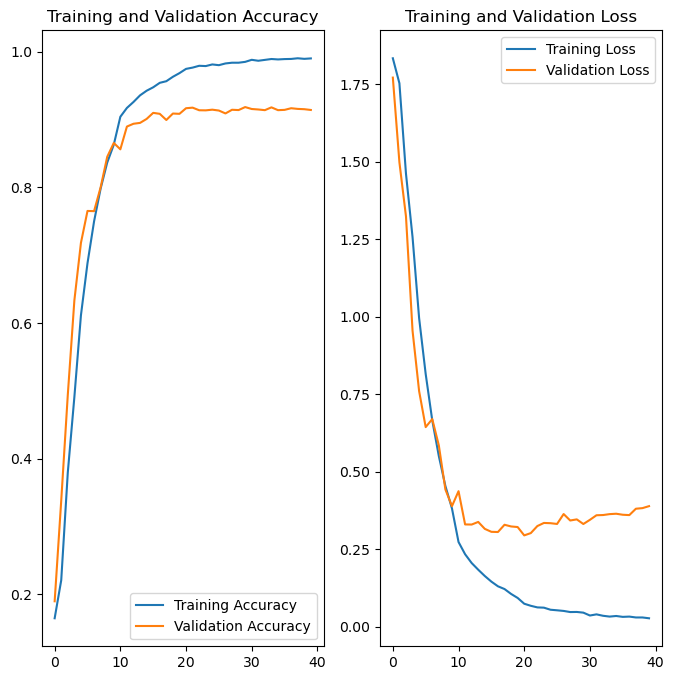

In [30]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [31]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

879/879 [==============================] - 14s 15ms/step
Confusion Matrix
[[1126   14   14   10    5   16]
 [   3 1085   10   16   41   22]
 [   8   57 1031   18   22   48]
 [   0    1    8 1169    0   10]
 [   0   83    2    0 1067    6]
 [   1   81   45   48   13  948]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.95      0.97      1185
           Aedes vexans       0.82      0.92      0.87      1177
     Anopheles sinensis       0.93      0.87      0.90      1184
          Culex pipiens       0.93      0.98      0.95      1188
Culex tritaeniorhynchus       0.93      0.92      0.93      1158
            Non vectors       0.90      0.83      0.87      1136

               accuracy                           0.91      7028
              macro avg       0.92      0.91      0.91      7028
           weighted avg       0.92      0.91      0.91      7028

Model is saved in ./models/Model_SDO_Park_2022-09-

In [32]:
#-----Run 10

In [33]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))

#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpnjiaoyyh/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpnjiaoyyh/train/Aedes vexans/ = 4726.
No. of files in "/tmp/tmpnjiaoyyh/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpnjiaoyyh/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpnjiaoyyh/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpnjiaoyyh/val/Aedes vexans/ = 1175.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpnjiaoyyh/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpnjiaoyyh/train/Anopheles sinensis/ = 4767.
No. of files in "/tmp/tmpnjiaoyyh/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpnjiaoyyh/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpnjiaoyyh/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpnjiaoyyh/val/Anopheles sinensis/ = 1156.
Foun

In [34]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28702 files belonging to 6 classes.
Found 7038 files belonging to 6 classes.


In [35]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/30-15:24:19

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3588/3588 [==============================] - 214s 58ms/step - loss: 1.8351 - accuracy: 0.1708 - val_loss: 1.7604 - val_accuracy: 0.2894 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3588/3588 [==============================] - 206s 57ms/step - loss: 1.6879 - accuracy: 0.2583 - val_loss: 1.4850 - val_accuracy: 0.3174 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3588/3588 [==============================] - 203s 57ms/step - loss: 1.4232 - accuracy: 0.3958 - val_loss: 1.2911 - val_accuracy: 0.4828 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3588/3588 [==============================] - 201s 56ms/step - loss: 1.2241 - accuracy: 0.5115 - val_loss: 1.0508 - val_accuracy: 0.598

Epoch 34/40
3588/3588 [==============================] - 200s 56ms/step - loss: 0.0317 - accuracy: 0.9895 - val_loss: 0.4137 - val_accuracy: 0.9032 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3588/3588 [==============================] - 203s 57ms/step - loss: 0.0289 - accuracy: 0.9907 - val_loss: 0.4480 - val_accuracy: 0.8997 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3588/3588 [==============================] - 201s 56ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.4158 - val_accuracy: 0.9049 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3588/3588 [==============================] - 201s 56ms/step - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.4272 - val_accuracy: 0.9018 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3588

Maximum test accuracy is at 91.28 %.


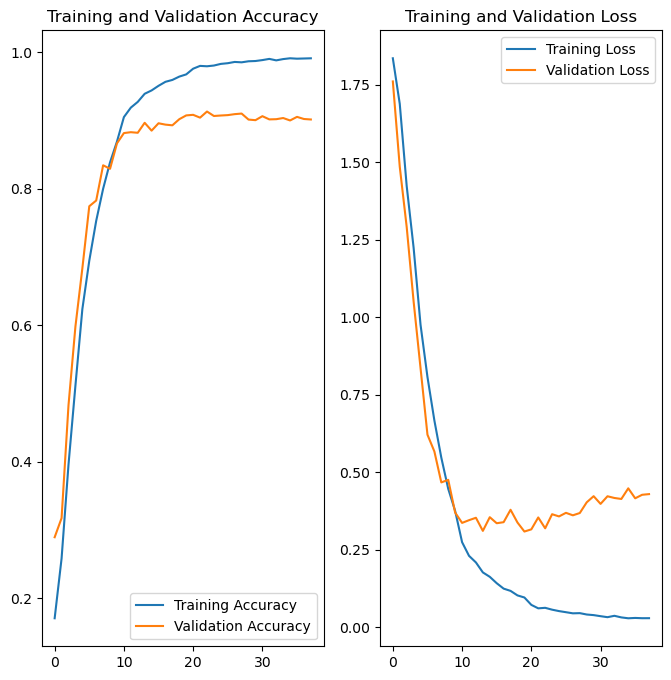

In [36]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [37]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

880/880 [==============================] - 14s 15ms/step
Confusion Matrix
[[1135    2    5    6   20    7]
 [   3 1063   17    7   60   25]
 [  13  106  981   10    7   39]
 [   5    4    6 1161    0   11]
 [   0   61    7    0 1081    8]
 [  14   44   30   96    1 1003]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.97      0.97      0.97      1175
           Aedes vexans       0.83      0.90      0.87      1175
     Anopheles sinensis       0.94      0.85      0.89      1156
          Culex pipiens       0.91      0.98      0.94      1187
Culex tritaeniorhynchus       0.92      0.93      0.93      1157
            Non vectors       0.92      0.84      0.88      1188

               accuracy                           0.91      7038
              macro avg       0.91      0.91      0.91      7038
           weighted avg       0.91      0.91      0.91      7038

Model is saved in ./models/Model_SDO_Park_2022-09-